In [1]:
# common imports
import pandas as pd
import numpy as np
import seaborn as sns

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [2]:
# load csv data
aisles = pd.read_csv('/Users/Nicole/Desktop/raw/aisles.csv')
dept = pd.read_csv('/Users/Nicole/Desktop/raw/departments.csv')
prod = pd.read_csv('/Users/Nicole/Desktop/raw/products.csv')
train = pd.read_csv('/Users/Nicole/Desktop/raw/order_products__prior.csv')
test = pd.read_csv('/Users/Nicole/Desktop/raw/order_products__train.csv')
orders = pd.read_csv('/Users/Nicole/Desktop/raw/orders.csv')
orders_clustered = pd.read_csv('/Users/Nicole/Desktop/raw/orders_clustered.csv')

df = [aisles, dept, prod, train, test, orders]
df_names = ['aisles','dept','prod','train','test','orders']

### C. EDA

#### Order Distribution

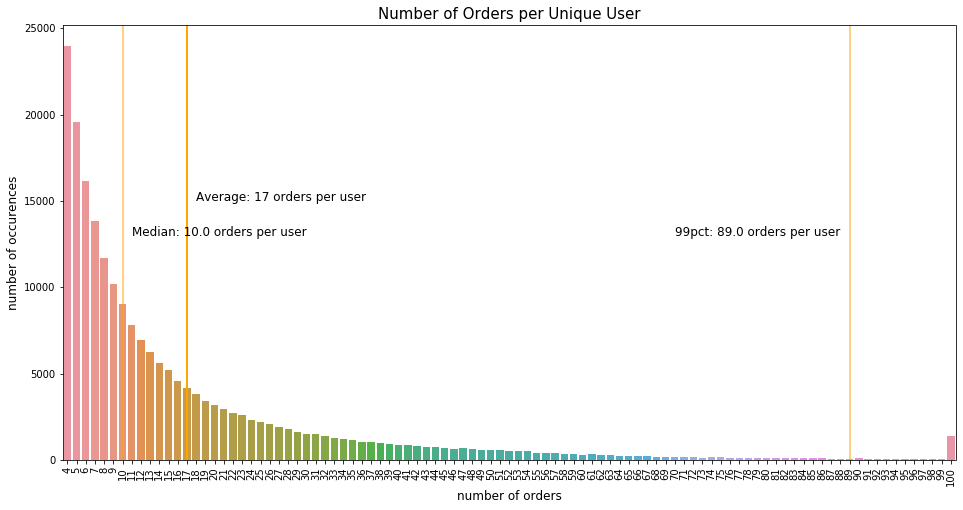

In [3]:
#Look at the distribution of the orders per user ID
user_max_order = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
max_order_count = user_max_order.order_number.value_counts()

#Plot the distribution
plt.figure(figsize=(16,8))
sns.barplot(max_order_count.index, max_order_count.values)
plt.title('Number of Orders per Unique User', fontsize=15)
plt.ylabel('number of occurences', fontsize=12)
plt.xlabel('number of orders', fontsize=12)
plt.xticks(rotation='vertical')

#Plot the vertical lines
plt.axvline(13, linestyle='-', color='orange', linewidth=2)
plt.axvline(6, linestyle='-', color='orange', alpha=0.5, linewidth=2)
plt.axvline(85, linestyle='-', color='orange', alpha=0.5, linewidth=2)
plt.text(14, 15000, 'Average: {} orders per user'.format(round(np.mean(user_max_order.order_number))), color = 'k', fontsize=12)
plt.text(7, 13000, 'Median: {} orders per user'.format(np.percentile(user_max_order.order_number, 50)), color = 'k', fontsize=12)
plt.text(66, 13000, '99pct: {} orders per user'.format(np.percentile(user_max_order.order_number, 99)), color = 'k', fontsize=12)

plt.show()

The maximum number of orders per user id is 99. This is an exponential distribution, intuitively this make sense.

**Insights:**

- The average number of order is 17 per user
- 1% of the customer order more than 89 times (party!!!)
- 50% of the customer order less than 10 times
- Assuming everything is equal this means the customer purchasing behaviour, as measured by number of repeat purchase, is sub-optimal. Thus perhaps marketing can boost their promotional efforts towards a subset of customers who order less than 16 times but more than 9 times, in a hope to close the gap.

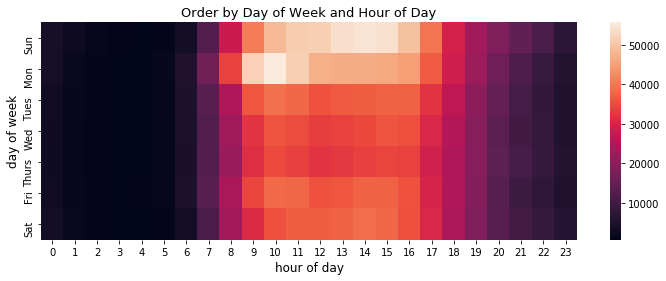

In [5]:
#Look at order distribution by Day of Week and Hour of Day

heatmap_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].count().reset_index()
heatmap_df = heatmap_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

yticks ='Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'

plt.figure(figsize=(12,4))
sns.heatmap(heatmap_df, yticklabels=yticks)
plt.title("Order by Day of Week and Hour of Day", fontsize = 13)
plt.ylabel("day of week", fontsize = 12)
plt.xlabel("hour of day", fontsize = 12)

plt.show()

**Insights:**

- In general, orders are placed everyday mostly between 10AM - 4PM
- Sunday and Monday are the busiest day for order placement
- The hottest timing for order placement is Sunday between 1 - 3PM and Monday between 9 - 11AM
- Wednesday and Thursday are less busy for order placement

#### Order Frequency

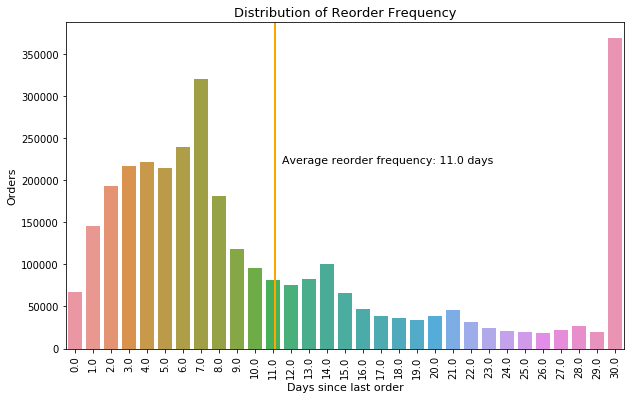

In [20]:
#Look at the distribution of lag-time between orders
plt.figure(figsize=(10, 6))
sns.countplot(x="days_since_prior_order", data=orders)
plt.ylabel("Orders",fontsize=11)
plt.xlabel('Days since last order',fontsize=11)
plt.xticks(rotation="vertical")
plt.title("Distribution of Reorder Frequency",fontsize=13)

plt.axvline(avg_days_per_count, linestyle='-', color='orange', linewidth=2)
plt.text(11.5, 220000, 'Average reorder frequency: {} days'.format(round(avg_days_per_count)), color = 'k', fontsize=11)
plt.show();

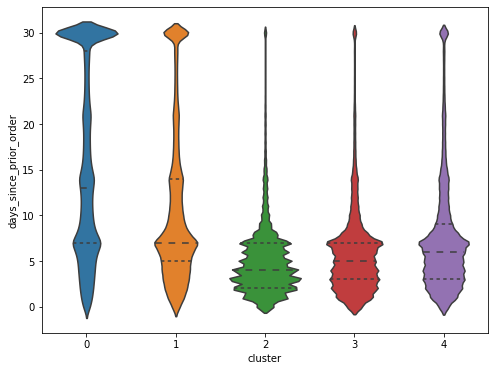

In [23]:
plt.figure(figsize=(8,6))
sns.violinplot(x="cluster", y="days_since_prior_order", data=orders_clustered, split=True, inner="quart")
plt.show()

**Insights:**

- There seems to be a capped variable (30 days)
- Gamma distribution
- The most common number of days between orders is exactly 1 week
- Users in Cluster 1/2 tend to have a wider time gap between purchases
- Users in cluster 3/4 are the most recurrent buyers

#### Most Popular Products/Aisles/Departments

In [23]:
# merge train data with product, aisle and product
orders_merged = pd.merge(pd.merge(pd.merge(train, prod, on="product_id",how="left"),\
                                  aisles, on="aisle_id", how="left"),\
                         dept, on="department_id", how="left")

In [55]:
# add cluster number to each order
orders_merged_clustered = orders_merged.join(orders_clustered[['order_id','cluster']].set_index('order_id'), on='order_id')
orders_merged_clustered.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,cluster
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,0


In [26]:
# Top 10 products
orders_merged['product_name'].value_counts().head(10)

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

- Most of the products are organic!

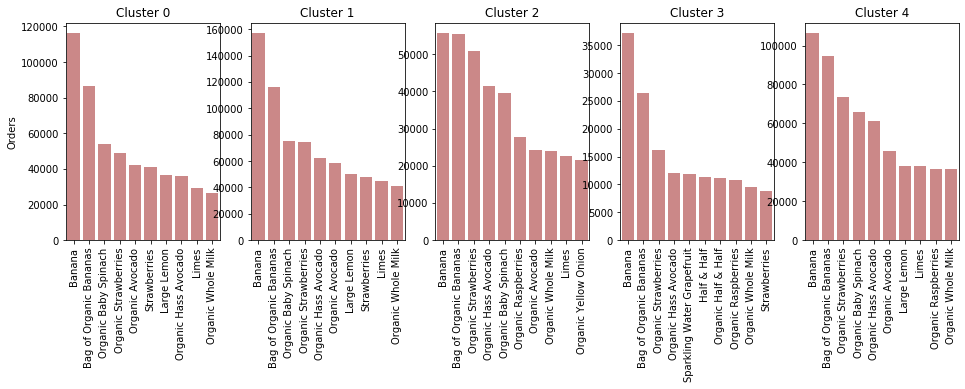

In [34]:
# Top 10 products for each cluster
number_figures = 5
labels = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4']

top_10_prod = []
for figure in range(number_figures):
    top_10_prod.append(orders_merged_clustered['product_name'][orders_merged_clustered.cluster==figure]\
                       .value_counts().head(10))

grid = GridSpec(1, 5)
plt.figure(figsize=(16,4))

for column in range(5):
    plt.subplot(grid[0,column])
    sns.barplot(top_10_prod[column].index, top_10_prod[column].values, alpha=0.8, color='indianred')
    if column == 0:
        plt.ylabel('Orders')
    plt.xticks(rotation='vertical')
    plt.title(labels[column])

plt.show()

- There are no obvious differences of the most popular products among clusters

In [35]:
# Top 10 aisles
orders_merged['aisle'].value_counts().head(10)

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

In [36]:
# Top 10 departments
orders_merged['department'].value_counts().head(10)

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
Name: department, dtype: int64

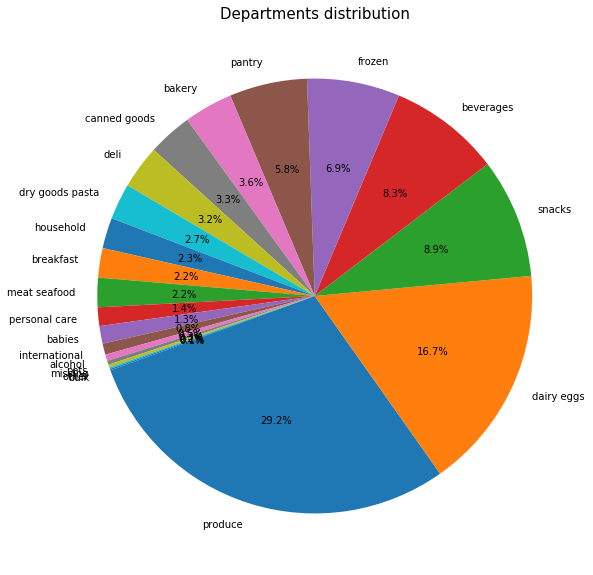

In [25]:
# departmentwise distribution of sales
plt.figure(figsize=(10,10))
dept_dist = orders_merged['department'].value_counts()
labels = (np.array(dept_dist.index))
sizes = (np.array((dept_dist / dept_dist.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution",fontsize=15)
plt.show()

**Insights:**

- Some departments have really infrequent sales
- Help eliminating some of the departments from recommending
- Produce,snacks and dairy eggs contribute to almost 50% transactions. This is an expected result as the the top department is Produce.

#### Reorder Ratios

In [38]:
# find percentage of ordered and reordered
orders_count = orders_merged.groupby('department').product_id.count()
pct_ordered = [i/sum(orders_count) for i in orders_count]

reorders_count = orders_merged.groupby('department').reordered.sum()
pct_reordered = [i/sum(reorders_count) for i in reorders_count]

In [39]:
# convert to dataframe
product_order = pd.DataFrame(orders_count).reset_index()
product_order['pct_ordered'] = pct_ordered
product_order['pct_reordered'] = pct_reordered
product_order.columns = ['department', 'orders_count', 'pct_ordered', 'pct_reordered']

product_order.head()

,department,orders_count,pct_ordered,pct_reordered
0,alcohol,153696,0.004739,0.004580
1,babies,423802,0.013066,0.012829
2,bakery,1176787,0.036282,0.038647
3,beverages,2690129,0.082940,0.091909
4,breakfast,709569,0.021877,0.020809


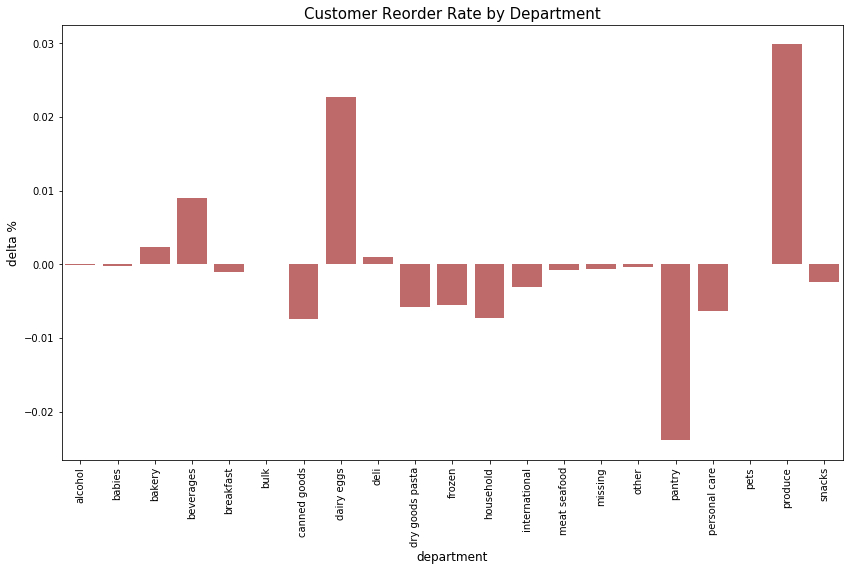

In [40]:
# reorder rate (% reordered - % ordered) by department
product_order['delta'] = product_order.pct_reordered - product_order.pct_ordered

plt.figure(figsize=(14,8))
sns.barplot(x='department', y='delta', data=product_order, color='indianred')
plt.title('Customer Reorder Rate by Department', fontsize=15)
plt.ylabel('delta %', fontsize=12)
plt.xlabel('department', fontsize=12)
plt.xticks(rotation=90)
plt.show()